# Kernel learning example

Here, we imagine that we want to use linear regression with a Gaussian kernel to fit a noisy sine wave.

In [1]:
using PyPlot
using Random
using LinearAlgebra
import Statistics.mean

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/cdesa/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
Random.seed!(123456);
N = 10000; # size of data set
x = 6 * rand(N);
y = sin.(x.^2) .+ 0.2 * randn(N);

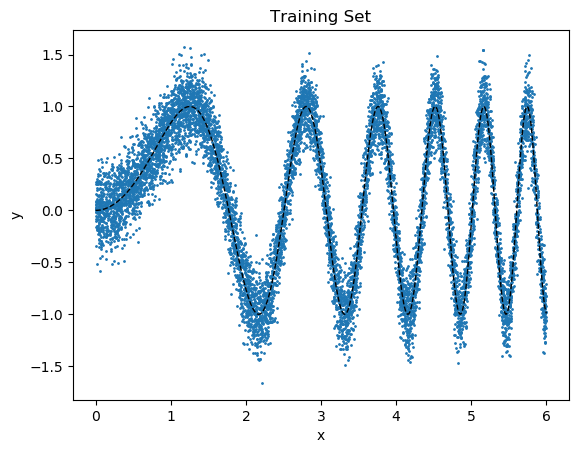

In [3]:
scatter(x,y; s=1);
plot(collect(0:0.01:6), sin.(collect(0:0.01:6).^2), "--k"; linewidth=1);
xlabel("x");
ylabel("y");
title("Training Set");

In [4]:
gamma = 100;
function K(x1, x2)
    return exp(-gamma*(x1 - x2)^2/2);
end

K (generic function with 1 method)

In [5]:
# compute the Gram matrix
@time begin
    G = zeros(N, N);
    for i = 1:N
        for j = 1:N
            G[i,j] = K(x[i], x[j]);
        end
    end
end

 24.635236 seconds (889.82 M allocations: 15.495 GiB, 8.20% gc time)


In [6]:
# actually solve the regularized linear regression problem
@time w = (G + 0.001 * LinearAlgebra.I) \ y;

  6.912073 seconds (3.70 M allocations: 1.664 GiB, 0.61% gc time)


In [7]:
function predict(xt :: Float64)
    rv = 0.0;
    for i = 1:N
        rv += w[i] * K(x[i], xt);
    end
    return rv;
end

predict (generic function with 1 method)

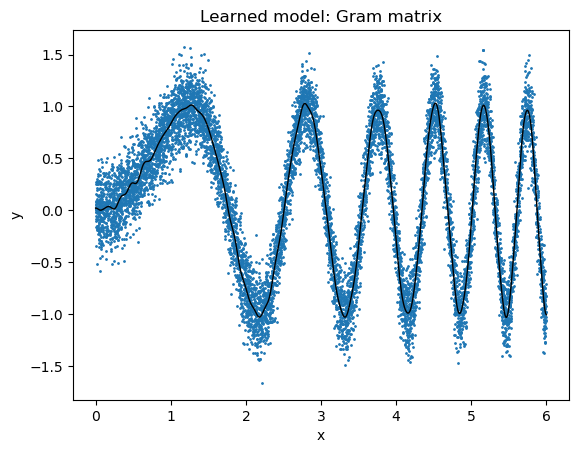

average test error: 0.01885103613764682


In [8]:
scatter(x,y; s=1);
x_test = collect(0:0.01:6);
y_test = sin.(x_test.^2);
y_pred = predict.(x_test);
plot(x_test, y_pred, "k"; linewidth=1);
xlabel("x");
ylabel("y");
title("Learned model: Gram matrix");

println("average test error: $(sqrt(mean((y_test - y_pred).^2)))")

## Now, what if we do it with random Fourier features?

In [9]:
D = 1000;
U = randn(D) * sqrt(gamma);
b = 2 * pi * rand(D);

In [10]:
# compute the feature map
@time begin
    phi = zeros(N, D);
    for i = 1:N
        for j = 1:D
            phi[i,j] = sqrt(2)*cos(U[j] * x[i] + b[j]);
        end
    end
end

  2.882314 seconds (99.89 M allocations: 1.714 GiB, 12.18% gc time)


In [11]:
# actually solve the (now not regularized) linear regression problem
@time w_rff = (phi' * phi + 0.001 * LinearAlgebra.I) \ (phi' * y);

  0.902046 seconds (3.16 M allocations: 172.741 MiB, 12.77% gc time)


In [12]:
function predict_rff(xt :: Float64)
    phi_xt = sqrt(2)*cos.(U .* xt .+ b);
    return dot(phi_xt, w_rff);
end

predict_rff (generic function with 1 method)

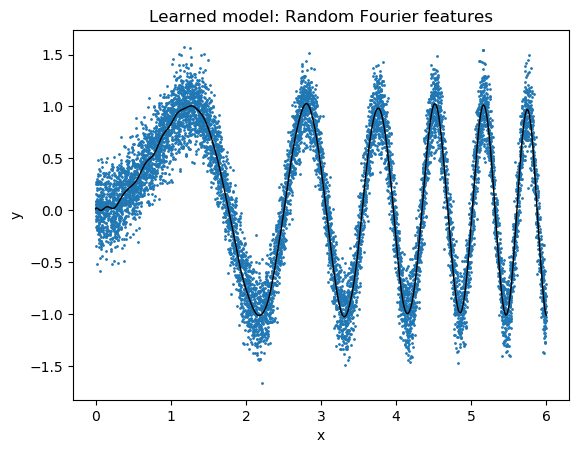

average test error: 0.015437442683226957


In [13]:
scatter(x,y; s=1);
x_test = collect(0:0.01:6);
y_test = sin.(x_test.^2);
y_pred = predict_rff.(x_test);
plot(x_test, y_pred, "k"; linewidth=1);
xlabel("x");
ylabel("y");
title("Learned model: Random Fourier features");

println("average test error: $(sqrt(mean((y_test - y_pred).^2)))")